In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy.special import gamma
from scipy.optimize import least_squares

In [ ]:
# Load the data
data_path = "../data/cps_clean_v3.csv"
df = pd.read_csv(data_path)

df = df[(df['INCZERO_TWO'] == 0)]

In [147]:
# Set parameters
num_incp_bins = 1000
num_inclog_bins = 2401

## Bin by INCPER and compute counts and average INCLOG within each bin

# Define equal-width bin edges for INCPER
bins_incp = np.linspace(0, 1, num_incp_bins + 1) 

# Create a new column with the bin index (0 to num_incp_bins-1)
df['incper_bin'] = pd.cut(df['INCPER'], bins=bins_incp, include_lowest=True, labels=False)

# Group by the bin and calculate count and average of INCLOG
bin_stats = df.groupby('incper_bin').agg(count=('INCPER', 'size'),
                                           avg_inc_log=('INCLOG', 'mean')).reset_index()

## Create a matrix of INCLOG_DELTA probability density estimates per INCPER bin
# Define equal-width bin edges for INCLOG_DELTA
bins_inclog_delta = np.linspace(-6, 6, num_inclog_bins + 1)

hist_matrix = np.zeros((num_incp_bins, num_inclog_bins))

# Loop through each INCPER bin to compute the histogram of INCLOG_DELTA (with clamping)
for bin_idx in range(num_incp_bins):
    # Select rows for the current INCPER bin
    bin_data = df.loc[df['incper_bin'] == bin_idx, 'INCLOG_DELTA']
    
    if not bin_data.empty:
        # Clamp values to the range [-6, 6]
        clamped = bin_data.clip(lower=-6, upper=6)
        # Compute normalized histogram
        hist, _ = np.histogram(clamped, bins=bins_inclog_delta, density=True)
        hist_matrix[bin_idx, :] = hist

# Convert the matrix into a DataFrame
matrix_df = pd.DataFrame(hist_matrix)

# Compute bin-center values for INCPER and INCLOG_DELTA
incper_centers = (bins_incp[:-1] + bins_incp[1:]) / 2
delta_centers = (bins_inclog_delta[:-1] + bins_inclog_delta[1:]) / 2

# Exclude incper bins where the incper center is <= 0.01
mask = incper_centers > 0.01
incper_centers = incper_centers[mask]
hist_matrix = hist_matrix[mask, :]
num_incp_bins = incper_centers.shape[0]

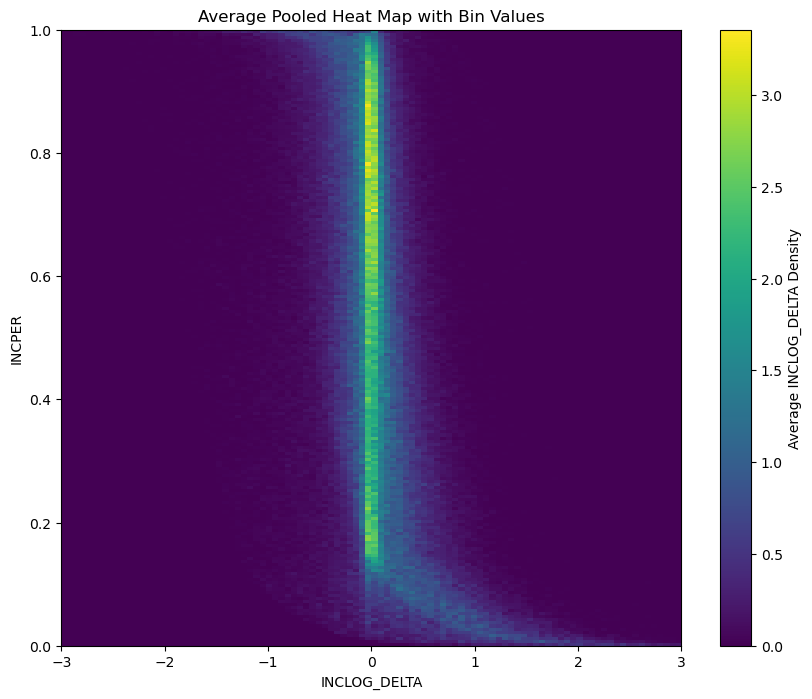

In [37]:
# Pooling parameters for each dimension
pool_rows = 5    # pool 5 rows together (from the 1000 INCPER bins dimension)
pool_cols = 6    # pool 6 columns together (from the 1200 INCLOG_DELTA bins dimension)

# Ensure the matrix dimensions are divisible by the pooling sizes
num_rows, num_cols = hist_matrix.shape
assert num_rows % pool_rows == 0 and num_cols % pool_cols == 0, "Matrix dimensions must be evenly divisible by pooling sizes."

# Average pool the matrix:
# 1. Reshape the matrix into a 4D array with shape (num_rows//pool_rows, pool_rows, num_cols//pool_cols, pool_cols)
# 2. Take the mean over the block axes (axis 1 and 3)
pooled_matrix = hist_matrix.reshape(num_rows // pool_rows, pool_rows,
                                    num_cols // pool_cols, pool_cols).mean(axis=(1, 3))

# Compute the original centers for each bin dimension
# For INCPER bins (rows), bin edges were stored in bins_incp
incper_centers = (bins_incp[:-1] + bins_incp[1:]) / 2.0  # length = num_incp_bins
# For INCLOG_DELTA bins (columns), bin edges were stored in bins_inclog_delta
inclog_delta_centers = (bins_inclog_delta[:-1] + bins_inclog_delta[1:]) / 2.0  # length = num_inclog_bins

# Average pool the bin centers to obtain centers for the pooled matrix.
# Each pooled bin is the average of multiple original bin centers.
pooled_y = incper_centers.reshape(num_rows // pool_rows, pool_rows).mean(axis=1)
pooled_x = inclog_delta_centers.reshape(num_cols // pool_cols, pool_cols).mean(axis=1)

# For imshow we need to set the extent so that the axes reflect the bin values.
# Compute half the average spacing along each pooled axis.
dx = np.mean(np.diff(pooled_x)) if len(pooled_x) > 1 else 1
dy = np.mean(np.diff(pooled_y)) if len(pooled_y) > 1 else 1

# The extent should cover the pooled bins from the edge of the first to the edge of the last.
extent = [pooled_x[0] - dx/2, pooled_x[-1] + dx/2,
          pooled_y[0] - dy/2, pooled_y[-1] + dy/2]

# Display the heat map of the average-pooled matrix with x and y axes labeled by the bin values.
plt.figure(figsize=(10, 8))
plt.imshow(pooled_matrix, origin='lower', cmap='viridis', aspect='auto', extent=extent)
plt.colorbar(label='Average INCLOG_DELTA Density')
plt.xlim(-3, 3)
plt.title('Average Pooled Heat Map with Bin Values')
plt.xlabel('INCLOG_DELTA')
plt.ylabel('INCPER')
plt.show()

In [ ]:
# Model definitions
#
# We model a mixture of three generalized normal distributions.
# For a generic set of parameters (mu, alpha, beta), we assume:
#
#   gnd_pdf(x; mu, alpha, beta) = ( beta / (2 * alpha * Gamma(1/beta)) )
#                                 * exp[ - (|x - mu| / alpha)^beta ]
#
# Mixture weights:
#   Promotional:  pi₁(x) = a_pi1 * exp(b_pi1 * x)   [with a_pi1=0.8, b_pi1=-4 initially]
#   Demotional:   pi₂(x) = a_pi2 * exp(b_pi2 * (1-x)) [with a_pi2=0.7, b_pi2=-8 initially]
#   Centralized weight = 1 - pi₁(x) - pi₂(x)
#
# Some parameters are defined as functions of INCPER via parabolic (quadratic)
# splines. For example, for the centralized component:
#   beta₀(x) is defined by a quadratic spline using 3 pieces (4 nodes) 
#   alpha₀(x) is defined by a quadratic spline using 5 pieces (6 nodes)
#
# The promotional component uses a 7-piece spline for mu₁(x) and a 3-piece 
# spline for alpha₁(x). The demotional component uses a 3-piece spline for mu₂(x)
# (and must remain between -0.5 and -0.01) and a 3-piece spline for alpha₂(x).
#
# The static parameters include:
#   mu₀ (centralized)  : init -0.007, bounds [-0.01, 0.01]
#   beta₁ (promotional) : init 2, bounds [1, 2.5]
#   beta₂ (demotional)  : init 1.5, bounds [1, 2.5]
#
# The residual function assembles the model prediction (for every INCPER bin and every
# INCLOG_DELTA bin center) and compares it to the observed densities (hist_matrix).
#
# The free parameters are collected in a single vector p (of length 37) as follows:
#
#  p[0]        : mu0 (centralized static) 
#  p[1:5]      : beta0 spline nodes (4 values; quadratic spline -> 3 segments)
#  p[5:11]     : alpha0 spline nodes (6 values; 5 segments)
#
#  p[11]       : a_pi1 
#  p[12]       : b_pi1 
#  p[13:21]    : mu1 spline nodes (8 values; 7 segments; >= 0.01)
#  p[21]       : beta1 (static)
#  p[22:26]    : alpha1 spline nodes (4 values; 3 segments; >= 0.01)
#
#  p[26]       : a_pi2 
#  p[27]       : b_pi2 
#  p[28:32]    : mu2 spline nodes (4 values; 3 segments; in (-0.5, -0.01))
#  p[32]       : beta2 (static)
#  p[33:37]    : alpha2 spline nodes (4 values; 3 segments; >= 0.01)
#

In [139]:
# Define knot vectors for the spline functions (domain is [0, 1])
knots_beta0   = np.linspace(0, 1, 4) 
knots_alpha0  = np.linspace(0, 1, 6)
knots_mu1     = np.linspace(0, 1, 8)
knots_alpha1  = np.linspace(0, 1, 4)
knots_mu2     = np.linspace(0, 1, 4)
knots_alpha2  = np.linspace(0, 1, 4)

# Generalized Normal PDF function
def gnd_pdf(x, mu, alpha, beta_param):
    coeff = beta_param / (2 * alpha * gamma(1 / beta_param))
    return coeff * np.exp(- (np.abs(x - mu) / alpha) ** beta_param)

def model_residuals(p):
    # Unpack parameters from p (length = 37)
    # Centralized component
    mu0          = p[0]             # static
    beta0_nodes  = p[1:5]           # spline nodes for beta0
    alpha0_nodes = p[5:11]          # spline nodes for alpha0
    
    # Promotional component
    a_pi1        = p[11]            # for pi1: exponential weight
    b_pi1        = p[12]
    mu1_nodes    = p[13:21]         # spline nodes for mu1 (>= 0.01)
    beta1        = p[21]            # static
    alpha1_nodes = p[22:26]         # spline nodes for alpha1 (>= 0.01)
    
    # Demotional component
    a_pi2        = p[26]            # for pi2: exponential weight
    b_pi2        = p[27]
    mu2_nodes    = p[28:32]         # spline nodes for mu2 (in (-0.5, -0.01))
    beta2        = p[32]            # static
    alpha2_nodes = p[33:37]         # spline nodes for alpha2 (>= 0.01)
    
    # Create the quadratic spline functions (k=2) for each parameter function.
    beta0_func   = make_interp_spline(knots_beta0, beta0_nodes, k=2)
    alpha0_func  = make_interp_spline(knots_alpha0, alpha0_nodes, k=2)
    mu1_func     = make_interp_spline(knots_mu1, mu1_nodes, k=2)
    alpha1_func  = make_interp_spline(knots_alpha1, alpha1_nodes, k=2)
    mu2_func     = make_interp_spline(knots_mu2, mu2_nodes, k=2)
    alpha2_func  = make_interp_spline(knots_alpha2, alpha2_nodes, k=2)
    
    # Evaluate the splines (vectorized) at each incper center
    beta0_vals   = beta0_func(incper_centers)
    alpha0_vals  = alpha0_func(incper_centers)
    mu1_vals     = mu1_func(incper_centers)
    alpha1_vals  = alpha1_func(incper_centers)
    mu2_vals     = mu2_func(incper_centers)
    alpha2_vals  = alpha2_func(incper_centers)
    
    # Evaluate the exponential functions for pi1 and pi2
    pi1_vals = a_pi1 * np.exp(b_pi1 * incper_centers)
    pi2_vals = a_pi2 * np.exp(b_pi2 * (1 - incper_centers))
    central_weight = 1 - pi1_vals - pi2_vals
    
    # For each incper bin (row), evaluate the mixture PDF over delta_centers.
    predicted = np.empty((num_incp_bins, num_inclog_bins))
    for i, inc in enumerate(incper_centers):
        pdf_central = gnd_pdf(delta_centers, mu0, alpha0_vals[i], beta0_vals[i])
        pdf_promo   = gnd_pdf(delta_centers, mu1_vals[i], alpha1_vals[i], beta1)
        pdf_demo    = gnd_pdf(delta_centers, mu2_vals[i], alpha2_vals[i], beta2)
        
        # Enforce the promotional component to be zero for inclog_delta values below 0.
        promo_mask = delta_centers >= 0
        pdf_promo = pdf_promo * promo_mask
        
        # Enforce the demotional component to be zero for inclog_delta values above 0.
        demo_mask = delta_centers <= 0
        pdf_demo = pdf_demo * demo_mask
        
        predicted[i, :] = (central_weight[i] * pdf_central +
                           pi1_vals[i]       * pdf_promo +
                           pi2_vals[i]       * pdf_demo)
    
    # Compute residuals (flattened difference between prediction and observed density)
    residual = (predicted - hist_matrix).ravel()
    return residual

In [135]:
# Build initial guesses (p0) for all 37 parameters:
p0 = np.concatenate([
    np.array([0]),             # mu0
    np.full(4, 1.0),                # beta0_nodes (4)
    np.full(6, 1.0),                # alpha0_nodes (6)
    np.array([0.8, -4.0]),           # a_pi1, b_pi1
    np.full(8, 0.1),                # mu1_nodes (8)
    np.array([2.0]),                # beta1
    np.full(4, 1.0),                # alpha1_nodes (4)
    np.array([0.7, -8.0]),           # a_pi2, b_pi2
    np.full(4, -0.1),               # mu2_nodes (4)
    np.array([1.5]),                # beta2
    np.full(4, 1.0)                 # alpha2_nodes (4)
])

# Set lower and upper bounds (each in the order of p0)
# Note: For the exponential parameters we bound a_pi1 and a_pi2 between 0 and 1.
#
lower_bounds = np.concatenate([
    np.array([-0.01]),              # mu0
    np.full(4, 0.1),                # beta0_nodes (> 0)
    np.full(6, 0.01),               # alpha0_nodes (> 0)
    np.array([0.0, -1000.0]),         # a_pi1 in [0,1]; b_pi1: expect negative, so set lower bound -1000
    np.full(8, 0.01),               # mu1_nodes (>=0.01)
    np.array([1.0]),                # beta1 lower bound
    np.full(4, 0.01),               # alpha1_nodes (> 0)
    np.array([0.0, -1000.0]),         # a_pi2 in [0,1]; b_pi2: no strong constraint, so large negative bound
    np.full(4, -0.5),               # mu2_nodes lower bound (-0.5)
    np.array([1.0]),                # beta2 lower bound
    np.full(4, 0.01)                # alpha2_nodes (> 0)
])
upper_bounds = np.concatenate([
    np.array([0.01]),              # mu0 upper bound
    np.full(4, 10.0),               # beta0_nodes upper
    np.full(6, 10.0),               # alpha0_nodes upper
    np.array([1.0, 0.0]),            # a_pi1 upper bound, b_pi1 upper (<=0)
    np.full(8, 1000.0),             # mu1_nodes (no specific constraint, use a large number)
    np.array([2.5]),               # beta1 upper bound
    np.full(4, 10.0),              # alpha1_nodes
    np.array([1.0, 1000.0]),          # a_pi2 upper, b_pi2 upper (large bound)
    np.full(4, -0.01),             # mu2_nodes upper (< -0.01)
    np.array([2.5]),               # beta2 upper bound
    np.full(4, 10.0)               # alpha2_nodes upper
])


In [148]:
# Optimize the model to best-fit the data in hist_matrix.
# We use least_squares to minimize the squared (flattened) residuals.
result = least_squares(model_residuals, p0, bounds=(lower_bounds, upper_bounds),
                       ftol=1e-5, xtol=1e-5, gtol=1e-5,
                       max_nfev=100, verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.6203e+04                                    6.33e+04    
       1              2         7.5961e+04      2.42e+02       2.61e-02       3.53e+05    
       2              3         7.5721e+04      2.41e+02       4.43e+00       1.34e+05    
       3              4         7.5680e+04      4.00e+01       1.63e+01       9.51e+04    
       4              5         7.5677e+04      3.34e+00       1.84e+00       3.74e+04    
       5              8         7.5676e+04      1.58e+00       4.35e-02       2.92e+04    
       6              9         7.5663e+04      1.23e+01       3.85e-03       1.86e+04    
       7             12         7.5661e+04      1.89e+00       2.57e-04       1.85e+04    
`xtol` termination condition is satisfied.
Function evaluations 12, initial cost 7.6203e+04, final cost 7.5661e+04, first-order optimality 1.85e+04.


In [149]:
print("Optimization success:", result.success)
print("Optimized parameters:")
print(result.x)

# After the optimization, set p0 to the optimized parameters
if result.success:
    p0 = result.x.copy()
    print("p0 has been updated to the optimized parameters.")
else:
    raise RuntimeError("Optimization did not converge; p0 remains unchanged.")

Optimization success: True
Optimized parameters:
[-5.01366233e-03  2.89990224e-01  6.15107807e-01  6.96661734e-01
  7.53257262e-01  4.49049556e-02  3.44758422e-02  1.02581830e-01
  9.57220491e-02  7.81356858e-02  6.39994363e-02  9.80072055e-01
 -4.83104501e+00  1.25546793e+00  2.91789198e-01  3.07401121e-01
  1.78206085e-01  1.20444808e-01  1.36641090e+00  3.20603877e+01
  1.93531223e+02  1.91536035e+00  6.39999712e-01  2.31155509e-01
  3.74148398e-01  1.77783861e+00  6.93343046e-01 -9.30255192e+00
 -3.48296214e-02 -4.85271687e-01 -3.60360790e-01 -3.84029192e-01
  1.62322057e+00  3.90558260e+00  6.85060293e-01  1.44163755e-01
  4.78569915e-01]
p0 has been updated to the optimized parameters.


In [150]:
# Define evaluation bin parameters
num_incp_bins_eval = 100      # New number of INCPER bins for evaluation
num_inclog_bins_eval = 121    # New number of INCLOG_DELTA bins for evaluation

# Define evaluation bin edges for INCPER and INCLOG_DELTA
bins_incp_eval = np.linspace(0, 1, num_incp_bins_eval + 1)
bins_inclog_delta_eval = np.linspace(-6, 6, num_inclog_bins_eval + 1)

# Create evaluation incper bin assignments
df['incper_bin_eval'] = pd.cut(df['INCPER'], bins=bins_incp_eval, include_lowest=True, labels=False)

# Initialize the evaluation histogram matrix
hist_eval_matrix = np.zeros((num_incp_bins_eval, num_inclog_bins_eval))

# Compute histogram for INCLOG_DELTA for each evaluation INCPER bin (with clamping)
for bin_idx in range(num_incp_bins_eval):
    bin_data = df.loc[df['incper_bin_eval'] == bin_idx, 'INCLOG_DELTA']
    if not bin_data.empty:
        clamped = bin_data.clip(lower=-6, upper=6)
        hist, _ = np.histogram(clamped, bins=bins_inclog_delta_eval, density=True)
        hist_eval_matrix[bin_idx, :] = hist

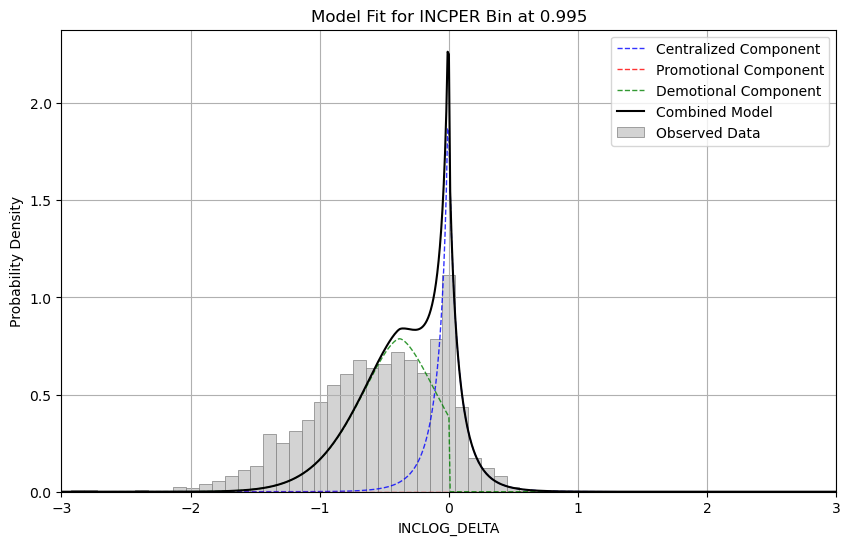

In [158]:
# Compute evaluation bin centers 
incper_centers_eval = (bins_incp_eval[:-1] + bins_incp_eval[1:]) / 2
delta_centers_eval = (bins_inclog_delta_eval[:-1] + bins_inclog_delta_eval[1:]) / 2
x_pdf = np.linspace(-6, 6, 1201)

# Specify the row index from hist_eval_matrix to plot (for example, row 50)
row_idx = 99
inc_eval = incper_centers_eval[row_idx]

# Extract the optimized parameters from p0
p = p0
mu0 = p[0]
beta0_nodes = p[1:5]
alpha0_nodes = p[5:11]

a_pi1 = p[11]
b_pi1 = p[12]
mu1_nodes = p[13:21]
beta1 = p[21]
alpha1_nodes = p[22:26]

a_pi2 = p[26]
b_pi2 = p[27]
mu2_nodes = p[28:32]
beta2 = p[32]
alpha2_nodes = p[33:37]

# Rebuild the spline functions (with quadratic splines, k=2) for parameter functions
beta0_func = make_interp_spline(knots_beta0, beta0_nodes, k=2)
alpha0_func = make_interp_spline(knots_alpha0, alpha0_nodes, k=2)
mu1_func = make_interp_spline(knots_mu1, mu1_nodes, k=2)
alpha1_func = make_interp_spline(knots_alpha1, alpha1_nodes, k=2)
mu2_func = make_interp_spline(knots_mu2, mu2_nodes, k=2)
alpha2_func = make_interp_spline(knots_alpha2, alpha2_nodes, k=2)

# Evaluate the spline functions at the chosen incper value for this evaluation bin
beta0_val = beta0_func(inc_eval)
alpha0_val = alpha0_func(inc_eval)
mu1_val = mu1_func(inc_eval)
alpha1_val = alpha1_func(inc_eval)
mu2_val = mu2_func(inc_eval)
alpha2_val = alpha2_func(inc_eval)

# Compute the component mixture weights for this incper value
pi1_val = a_pi1 * np.exp(b_pi1 * inc_eval)
pi2_val = a_pi2 * np.exp(b_pi2 * (1 - inc_eval))
central_weight_val = 1 - pi1_val - pi2_val

# Evaluate the PDFs for each component on the evaluation INCLOG_DELTA grid
pdf_central = gnd_pdf(x_pdf, mu0, alpha0_val, beta0_val)
pdf_promo = gnd_pdf(x_pdf, mu1_val, alpha1_val, beta1)
pdf_demo = gnd_pdf(x_pdf, mu2_val, alpha2_val, beta2)

# Modify promotional and demotional PDFs:
# Promotional component falls to 0 for inclog_delta < 0
# Demotional component falls to 0 for inclog_delta > 0
promo_mask = (x_pdf >= 0)
demo_mask = (x_pdf <= 0)
pdf_promo = pdf_promo * promo_mask
pdf_demo = pdf_demo * demo_mask

combined_pdf = central_weight_val * pdf_central + pi1_val * pdf_promo + pi2_val * pdf_demo

# Plot observed data as a bar graph (histogram style) and overlay the model components
plt.figure(figsize=(10, 6))
bar_width = bins_inclog_delta_eval[1] - bins_inclog_delta_eval[0]
plt.bar(delta_centers_eval, hist_eval_matrix[row_idx],
        width=bar_width, color='lightgrey', edgecolor='grey', linewidth=0.5, label='Observed Data')

plt.plot(x_pdf, central_weight_val * pdf_central, 'b--', linewidth=1, alpha=0.8, label='Centralized Component')
plt.plot(x_pdf, pi1_val * pdf_promo, 'r--', linewidth=1, alpha=0.8, label='Promotional Component')
plt.plot(x_pdf, pi2_val * pdf_demo, 'g--', linewidth=1, alpha=0.8, label='Demotional Component')
plt.plot(x_pdf, combined_pdf, 'k-', linewidth=1.5, label='Combined Model')

plt.xlabel('INCLOG_DELTA')
plt.ylabel('Probability Density')
plt.title(f'Model Fit for INCPER Bin at {inc_eval:.3f}')
plt.xlim(-3, 3)
plt.legend()
plt.grid(True)
plt.show()

In [155]:
# Load the original data into a new dataframe
df_comp = pd.read_csv(data_path)

# Initialize component columns
df_comp['comp_zero'] = 0.0
df_comp['comp_central'] = 0.0
df_comp['comp_promo'] = 0.0
df_comp['comp_demo'] = 0.0

# Rebuild the spline functions from the optimized parameters in p0
p = p0  # p0 is assumed to have been set to the optimized parameters

mu0 = p[0]
beta0_nodes = p[1:5]
alpha0_nodes = p[5:11]

a_pi1 = p[11]
b_pi1 = p[12]
mu1_nodes = p[13:21]
beta1 = p[21]
alpha1_nodes = p[22:26]

a_pi2 = p[26]
b_pi2 = p[27]
mu2_nodes = p[28:32]
beta2 = p[32]
alpha2_nodes = p[33:37]

beta0_func = make_interp_spline(knots_beta0, beta0_nodes, k=2)
alpha0_func = make_interp_spline(knots_alpha0, alpha0_nodes, k=2)
mu1_func    = make_interp_spline(knots_mu1, mu1_nodes, k=2)
alpha1_func = make_interp_spline(knots_alpha1, alpha1_nodes, k=2)
mu2_func    = make_interp_spline(knots_mu2, mu2_nodes, k=2)
alpha2_func = make_interp_spline(knots_alpha2, alpha2_nodes, k=2)

# For instances with INCZERO_TWO == 0, set comp_zero to 1 and the rest to 0.
mask_zero = df_comp['INCZERO_TWO'] == 1
df_comp.loc[mask_zero, 'comp_zero'] = 1
df_comp.loc[mask_zero, ['comp_central', 'comp_promo', 'comp_demo']] = 0

# For the other instances, compute the component likelihoods
mask_nonzero = ~mask_zero
if mask_nonzero.sum() > 0:
    # Get INCPER and INCLOG_DELTA for these rows
    incper_vals = df_comp.loc[mask_nonzero, 'INCPER'].values
    inclog_delta_vals = df_comp.loc[mask_nonzero, 'INCLOG_DELTA'].values

    # Evaluate spline functions to get the parameter values at each INCPER
    beta0_vals  = beta0_func(incper_vals)
    alpha0_vals = alpha0_func(incper_vals)
    mu1_vals    = mu1_func(incper_vals)
    alpha1_vals = alpha1_func(incper_vals)
    mu2_vals    = mu2_func(incper_vals)
    alpha2_vals = alpha2_func(incper_vals)

    # Compute mixture weights for promotional and demotional components
    pi1_vals = a_pi1 * np.exp(b_pi1 * incper_vals)
    pi2_vals = a_pi2 * np.exp(b_pi2 * (1 - incper_vals))
    central_weight_vals = 1 - pi1_vals - pi2_vals

    # Evaluate the likelihoods for each component
    L_central = central_weight_vals * gnd_pdf(inclog_delta_vals, mu0, alpha0_vals, beta0_vals)
    pdf_promo = gnd_pdf(inclog_delta_vals, mu1_vals, alpha1_vals, beta1)
    # Promotional component becomes 0 for inclog_delta < 0
    pdf_promo = np.where(inclog_delta_vals >= 0, pdf_promo, 0)
    L_promo = pi1_vals * pdf_promo

    pdf_demo  = gnd_pdf(inclog_delta_vals, mu2_vals, alpha2_vals, beta2)
    # Demotional component becomes 0 for inclog_delta > 0
    pdf_demo = np.where(inclog_delta_vals <= 0, pdf_demo, 0)
    L_demo  = pi2_vals * pdf_demo

    # To avoid division by zero, add a small epsilon
    epsilon = 1e-12
    L_sum = L_central + L_promo + L_demo + epsilon

    # Compute the component responsibilities (which sum to 1)
    resp_central = L_central / L_sum
    resp_promo   = L_promo / L_sum
    resp_demo    = L_demo / L_sum

    # Assign the computed probabilities to the dataframe and set comp_zero = 0
    df_comp.loc[mask_nonzero, 'comp_zero']    = 0
    df_comp.loc[mask_nonzero, 'comp_central'] = resp_central
    df_comp.loc[mask_nonzero, 'comp_promo']   = resp_promo
    df_comp.loc[mask_nonzero, 'comp_demo']    = resp_demo

# Append/update the csv file with the new columns
df_comp.to_csv(data_path, index=False)